In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_PATH = "/home/s4kibart/ba/data"
MODEL_PATH = "./pretrained_model"

In [2]:
from evaluate_cbr.visualize import export_graph
import uuid
import arguebuf as ab
from PIL import Image
import os

class ImageGraph:    
    def __init__(self, path, image_path=None) -> None:
        try:
            self.path = path
            self.graph: ab.Graph = ab.load.file(path)
            if image_path is None:
                self.image_path = "/tmp" + str(uuid.uuid4()) + ".png"
                export_graph(self.graph, self.image_path)
            else:
                self.image_path = image_path
                # raise exception if image_path is not valid
                if not os.path.exists(self.image_path):
                    raise Exception("Image path does not exist")                  
            self.image = Image.open(self.image_path).convert("RGB")
        except Exception as e:
            self.graph = None


In [3]:
import math

def heuristic_distance(g1: ImageGraph, g2: ImageGraph) -> float:
    graph1 = g1.graph
    graph2 = g2.graph
    no_edges = len(graph1.edges)
    no_i_nodes = len(graph1.atom_nodes)
    no_s_nodes = len(graph1.scheme_nodes)


    # calculate statistics for graph 2
    no_edges2 = len(graph2.edges)
    no_i_nodes2 = len(graph2.atom_nodes)
    no_s_nodes2 = len(graph2.scheme_nodes)


    # calculate normalized deltas
    delta_edges = (no_edges - no_edges2)
    delta_i_nodes = (no_i_nodes - no_i_nodes2)
    delta_s_nodes = (no_s_nodes - no_s_nodes2)


    # calculate euclidean distance
    return math.sqrt(delta_edges ** 2 + delta_i_nodes ** 2 + delta_s_nodes ** 2)

In [4]:
import torch
from torchvision.transforms import v2

transforms = v2.Compose([
    # v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.RandomRotation(45, fill=1),
    v2.RandomAffine(degrees=(-179, 180), translate=(0.1, 0.3), scale=(0.5, 0.75), fill=1),
    # v2.RandomResizedCrop((224, 224), antialias=True),
    # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    v2.RandomZoomOut(fill=1),
    v2.Resize((224, 224), antialias=True),
    v2.ElasticTransform(fill=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

/home/s4kibart/ba/evaluate_cbr/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from torch.utils.data import Dataset

class ImageGraphDataset:

    def __init__(self, paths: list[str], image_paths: list[str]) -> None:
        self.graphs: list[ImageGraph] = []
        for path, image_path in zip(paths, image_paths):
            g = ImageGraph(path, image_path)
            if g.graph is not None:
                self.graphs.append(g)

    def __len__(self) -> int:
        return len(self.graphs)
    
    def __getitem__(self, index: int) -> ImageGraph:
        return self.graphs[index]

In [6]:
import os
os.getcwd()

'/home/s4kibart/ba'

In [7]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained(MODEL_PATH)

In [8]:
from glob import glob
graph_paths = {"araucaria": "json", "iac": "json", "kialo-graphnli": "json", "microtexts": "json", "persuasive-essays": "ann", "qt30": "json", "us-2016": "json"}
paths_dict = {k: glob(f"{BASE_PATH}/{k}/*.{v}") for k, v in graph_paths.items()}
# sort paths
for k, v in paths_dict.items():
    paths_dict[k] = sorted(v)

image_paths_dict = {k: glob(f"{BASE_PATH}/{k}-images/*.png") for k in graph_paths.keys()}
# sort paths
for k, v in image_paths_dict.items():
    image_paths_dict[k] = sorted(v)

datasets = {k: ImageGraphDataset(v, image_paths_dict[k]) for k, v in paths_dict.items()}


In [9]:
for d in datasets.values():
    print(len(d))

# old:
# 662
# 1808
# 1560
# 110
# 402
# 1484
# 441

290
609
1560
83
395
1475
371


In [50]:
import torch
from transformers import Swinv2Model, AutoImageProcessor
import numpy as np

model = Swinv2Model.from_pretrained(MODEL_PATH)
processor = AutoImageProcessor.from_pretrained(MODEL_PATH)

class ImageTriplesDataset(Dataset):

    def __init__(self, datasets: dict[str, ImageGraphDataset], num_pos: int, num_neg: int, num_hard_neg: int) -> None:
        assert num_neg > num_hard_neg
        self.datasets = datasets
        self.num_pos = num_pos
        self.num_neg = num_neg
        self.num_hard_neg = num_hard_neg
        self.current_dataset = 0
        self.datasets_names = [d for d in datasets.keys()]
        self.lengths = [len(d) for d in datasets.values()]

    def __len__(self) -> int:
        return sum([len(d) for d in self.datasets.values()])
    
    def __getdataset__(self, index: int) -> tuple[int, int]:
        i = 0
        while index >= self.lengths[i]:
            index -= self.lengths[i]
            i += 1
        return i, index
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        dataset_idx, index = self.__getdataset__(index)
        dataset = self.datasets[self.datasets_names[dataset_idx]]
        anchor = dataset[index]
        anchor_tensor = processor(anchor.image, return_tensors="pt", padding=True)["pixel_values"]

        positives = [transforms(anchor_tensor).squeeze() for _ in range(self.num_pos + 1)] # positves = random transforms of anchor
        anchor_tensor = positives[0]
        positives = torch.stack(positives[1:])
        # negative_indices = torch.randint(0, len(self.dataset), (self.num_neg,)).tolist()
        # negatives = [self.dataset[i] for i in negative_indices] # negatives = random graphs from dataset

        negative_space = []
        for d in self.datasets.values():
            negative_space.extend(d.graphs)
        negative_space = np.array(negative_space)

        # use numpy to sample negatives to avoid duplicates
        negatives = np.random.choice(negative_space, self.num_neg, replace=False).tolist()


        # sort negatives by distance to anchor
        negatives_2 = np.random.choice(dataset, min(self.num_neg, len(dataset)), replace=False).tolist()
        negatives_2.sort(key=lambda x: heuristic_distance(anchor, x))
        hard_negatives = negatives_2[:self.num_hard_neg]
        negatives += hard_negatives
         
        negatives_tensor = [processor(n.image, return_tensors="pt", padding=True)["pixel_values"].squeeze() for n in negatives]
        negatives = [transforms(neg).squeeze() for neg in negatives_tensor]
        negatives_tensor = torch.stack(negatives)

        return anchor_tensor, positives, negatives_tensor
    
    def get_labels(self) -> torch.Tensor:
        positives = torch.zeros(self.num_pos + 1)
        negatives = torch.arange(1, self.num_neg + self.num_hard_neg + 1)
        return torch.cat((positives, negatives))


# Achtung
Wenn ich die Hard Negatives versuche zu erstellen wie bisher, erhalte ich Dopplungen, da zuerst nach heuristischer Distanz sortiert wird und im Datensatz im Allgemeinen Graphen mit gleicher Struktur enthalten sind.
## Lösung
Duplikate im Datensatz eliminieren. Achte dabei darauf, dass die entsprechenden Graphen auch eliminiert werden, nicht nur die Bilder. Alternativ: In ImageGraph erkennen

In [51]:
ds = ImageTriplesDataset(datasets, 2, 11, 2)

In [52]:
anchor, positives, negatives = ds[0]
print(anchor.shape)
print(positives.shape)
print(negatives.shape)

torch.Size([3, 224, 224])
torch.Size([2, 3, 224, 224])
torch.Size([13, 3, 224, 224])


In [53]:
import torchvision.transforms as T

tra = T.ToPILImage()

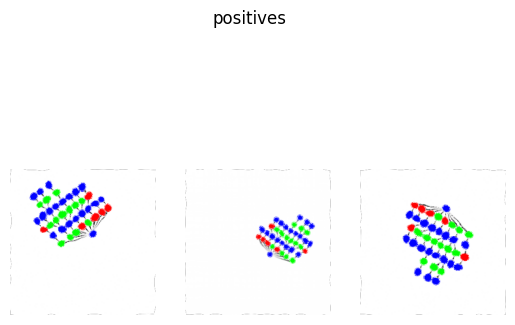

In [54]:
# display 3 images next to each other
import matplotlib.pyplot as plt
import numpy as np

def show_images(images: list[torch.Tensor], title: str = "") -> None:
    fig, axs = plt.subplots(1, len(images))
    fig.suptitle(title)
    for i, image in enumerate(images):
        axs[i].imshow(tra(image.squeeze()))
        axs[i].axis("off")
    plt.show()

anchor, positives, negatives = ds[2000]
show_images([anchor, *positives], "positives")


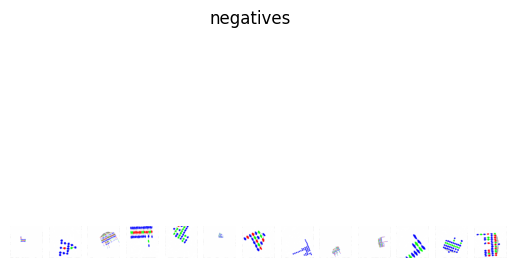

In [55]:
show_images([*negatives], "negatives")

In [56]:
len(ds)

4783

In [57]:
# export ds to file via torch.save
# torch.save(ds, "triples_dataset.pt")

In [58]:
ds[0][2].shape

torch.Size([13, 3, 224, 224])

In [59]:
import torch
from torch.nn import Linear, Sequential, ReLU, Dropout
from transformers import Swinv2Model, AutoImageProcessor

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.processor = AutoImageProcessor.from_pretrained(MODEL_PATH)
        self.model = Swinv2Model.from_pretrained(MODEL_PATH)
        self.projection_head = Sequential(
            Linear(768, 256),
            ReLU(inplace=True),
            Dropout(0.05),
            Linear(256, 32),
        )

    def forward(self, x, train = True):
        if train:
            # x = self.processor(x, return_tensors="pt", padding=True)
            x = self.model(x).pooler_output
            x = self.projection_head(x)
            return x
        else:
            x = self.processor(x, return_tensors="pt", padding=True)
            x = self.model(**x).pooler_output
            return x

In [72]:
from pytorch_metric_learning.losses import NTXentLoss
loss_func = NTXentLoss(temperature=0.5)

model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [73]:
anchor, positives, negatives = ds[0]
print(anchor.shape)
print(positives.shape)
print(negatives.shape)

torch.Size([3, 224, 224])
torch.Size([7, 3, 224, 224])
torch.Size([56, 3, 224, 224])


In [74]:
ds = ImageTriplesDataset(datasets, 7, 50, 6)

In [75]:
import torch
from torch.utils.data import DataLoader
def collate_fn(batch):
    anchor, positives, negatives = batch[0]
    return torch.cat((anchor.unsqueeze(0), positives, negatives))

train_loader = DataLoader(ds, collate_fn=collate_fn, batch_size=1, shuffle=True, num_workers=22)

In [76]:
for _, data in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    # Get data representations
    embeddings = model(data)
    print(embeddings)
    # The same index corresponds to a positive pair
    labels = ds.get_labels().to(device)
    print(labels)
    loss = loss_func(embeddings, labels)
    loss.backward()
    print(loss)
    break

tensor([[-0.0659,  0.0423,  0.1305,  ..., -0.3704, -0.0641, -0.2220],
        [-0.2673, -0.0207, -0.0190,  ..., -0.3452,  0.0087, -0.0639],
        [-0.1967, -0.0239,  0.0883,  ..., -0.3142,  0.0258, -0.0328],
        ...,
        [-0.3067,  0.1145, -0.0285,  ..., -0.3214,  0.0300,  0.1130],
        [-0.3128,  0.1530, -0.0185,  ..., -0.1266,  0.1047,  0.2056],
        [-0.3196,  0.0648, -0.0134,  ..., -0.3700, -0.0660, -0.1325]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,
         7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
        21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34.,
        35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
        49., 50., 51., 52., 53., 54., 55., 56.], device='cuda:0')
tensor(3.9157, device='cuda:0', grad_fn=<MeanBackward0>)


In [78]:
import tqdm

def train():
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm.tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        # Get data representations
        embeddings = model(data)
        # The same index corresponds to a positive pair
        labels = ds.get_labels().to(device)
        loss = loss_func(embeddings, labels)
        loss.backward()
        total_loss += loss.item() * data.shape[0]
        optimizer.step()
    return total_loss / len(ds)

for epoch in range(1, 10):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|████████████████████████████████████████████████████████| 4783/4783 [26:37<00:00,  2.99it/s]


Epoch 001, Loss: 258.7645


100%|████████████████████████████████████████████████████████| 4783/4783 [26:36<00:00,  3.00it/s]


Epoch 002, Loss: 258.7572


  7%|████▏                                                    | 349/4783 [02:06<26:46,  2.76it/s]


KeyboardInterrupt: 